# Align Fasta to Reference Fasta

In [16]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt
from itertools import groupby
import os
import re as re

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(f"Current machine: {socket_name}")
if socket_name == "DESKTOP-5RJD9NC":
    path = "/gitProjects/covid19_data"   # The Path on Harald's machine
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

Current machine: DESKTOP-5RJD9NC
D:\gitProjects\covid19_data


### Clean Fasta File (remove is)

In [92]:
def write_fasta(sample_line, seq_lines, savepath="", output=True):
    """Write a single Fasta file.
    sample_line: Line of the Sample to write
    seq_lines: Genotype Sequences to write
    savepath: Where to write Fasta File to
    """
    f1 = open(savepath, "w")
    f1.write(sample_line)  # Write the new line
    for line in seq_lines:
        f1.write(line)
    f1.close()
    if output:
        print(f"Saved fasta to {savepath}")
    
def fasta_iter_raw(fasta_name):
    """
    Return iterator for fasta
    """
    
    "first open the file outside "
    fh = open(fasta_name)
    # ditch the boolean (x[0]) and just keep the header or sequence since
    # we know they alternate.
    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    
    for header in faiter:
        # drop the ">"
        headerStr = header.__next__()   #[1:].strip()
        # join all sequence lines to one.
        seq = "".join(s for s in faiter.__next__())  # .strip()
        yield (headerStr, seq) 
        
def fasta_iter(fasta_name):
    """
    Return iterator for fasta
    """
    "first open the file outside "
    fh = open(fasta_name)
    # ditch the boolean (x[0]) and just keep the header or sequence since
    # we know they alternate.
    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))

    for header in faiter:
        # drop the ">"
        headerStr = header.__next__()[1:].strip()
        # join all sequence lines to one.
        seq = "".join(s.strip() for s in faiter.__next__())
        yield (headerStr, seq) 
        
def clean_seq_line(seq_line, replace_char=r'[^ACGTN\n\r]',
                   with_char="N"):
    """Clean seq_line String.
    Return updated string"""
    seq_line = seq_line.upper()   # Make Upper Case
    seq_line = re.sub(replace_char, with_char, seq_line)
    return seq_line

def include_samples(sample_seq, min_cov_bs):
    """Quick check whether to include sample.
    min_cov_bs: Minimum Number of covered Bases
    return include status, nr covered bases"""
    lgth = len(sample_seq) - sample_seq.count('\n') - sample_seq.count("N")
    include = True
    if lgth < min_cov_bs:
        include = False
    return include, lgth
        
def split_fasta(fasta_name, path_out="./output/singleseq/", 
                iids=[], clean=True, 
                min_cov_bs=20000, output=True):
    """
    Splits up samples from fasta if IID string contains
    clean: Whether to clean string (make everything upper-case 
    and substitute with N)
    min_cov_bs: How many bases covered at least once
    Return list of samples that have been run
    """
    fiter = fasta_iter_raw(fasta_name)
    
    iids_org, iids_prcsd = [], []
    cvg, icld = [], []
    
    for sample_line, seq_line in fiter:
        sample = sample_line[1:].strip()
        if sample in iids:
            if output:
                print(f"Matched: {sample}")
            sample1 = re.sub("[\|\/]", ".", sample)
            
            if clean:
                seq_line = clean_seq_line(seq_line)
                
            include, lgth = include_samples(seq_line, min_cov_bs=min_cov_bs)
            
            ### Append Statistics
            iids_org.append(sample)
            iids_prcsd.append(sample1)
            cvg.append(lgth)
            icld.append(include)
            
            if include:
                fasta_name_out = os.path.join(path_out, sample1 + ".fasta")
                write_fasta(sample_line, seq_line, fasta_name_out, output=output)
                
    # Make a Summary Dataframe
    df = pd.DataFrame({"iid":iids_org, "iid_clean":iids_prcsd, 
                        "cov":cvg,  "include":icld})
    return df
                  
def clean_fasta(fasta_name, fasta_name_out):
    """
    Remove invalid characters in sequences
    """
    "first open the file outside "
    f = open(fasta_name)
    f1 = open(fasta_name_out, "w")
    n=0
    
    for line in f:
        if line[0]==">":
            n+=1
        else:   # If Genome Data replace i
            line = line.replace("i", "N")
        f1.write(line)  # Write the new line
    f.close()
    f1.close()
    print(f"Successfully Modified {n} fastas")
    print(f"Saved to {clean_fasta_path}")

### Split up the Multi FASTA

In [102]:
%%time
df = split_fasta(fasta_name="./data/mar20/gisaid_cov2020_sequences_26.fasta", 
            path_out="./output/singleseq/", 
            iids=iids[:500], clean=True, min_cov_bs=20000, output=False)

Wall time: 9.58 s


In [110]:
df["include"].value_counts()
savepath = "./output/single_seq_split.tsv"
df.to_csv(savepath, sep="\t")
print(f"Saved Summary Dataframe n={len(df)} to {savepath}")

Saved Summary Dataframe n=500 to ./output/single_seq_split.tsv


### Create Dataframe of alredy processed Individuals

In [81]:
ls

['hCoV-19.USA.WA-S88.2020.EPI_ISL_417141.2020-03-01',
 'hCoV-19.USA.WA-S89.2020.EPI_ISL_417142.2020-02-29',
 'hCoV-19.USA.WA-S87.2020.EPI_ISL_417140.2020-03-01',
 'hCoV-19.USA.WA-S92.2020.EPI_ISL_417145.2020-02-29',
 'hCoV-19.USA.WA-S93.2020.EPI_ISL_417146.2020-02-29',
 'hCoV-19.USA.WA-S90.2020.EPI_ISL_417143.2020-02-29',
 'hCoV-19.USA.WA-S91.2020.EPI_ISL_417144.2020-03-02',
 'hCoV-19.USA.WA-S96.2020.EPI_ISL_417149.2020-02-28',
 'hCoV-19.USA.WA-S94.2020.EPI_ISL_417147.2020-02-28',
 'hCoV-19.USA.WA-S95.2020.EPI_ISL_417148.2020-02-28']

In [4]:
%%time
bin_path = "bins/mafft-win/mafft.bat"
out_path = "./output/aligned/test_out.fasta"
ref_path = "./data/reference/wuhan-hu-1.fasta"

fasta_path = "./data/mar20/gisaid_cov2020_sequences_26.fasta"
clean_fasta_path = "./data/mar20/gisaid_cov2020_sequences_26_c.fasta"
threads = 4

clean_fasta(fasta_path, clean_fasta_path)

Successfully Modified 1871 fastas
Saved to ./data/mar20/gisaid_cov2020_sequences_26_c.fasta
Wall time: 1.81 s


### Extract Single Sequence Fasta file

In [65]:
%%time
split_fasta(fasta_name = "./data/mar20/gisaid_cov2020_sequences_26.fasta",
            path_out="./output/singleseq/",
            fasta_name_out = fasta_name_out)

TypeError: split_fasta() got an unexpected keyword argument 'fasta_name_out'

In [50]:
def align_sequence(bin_path, out_path, fasta_name_out, 
                   ref_path, bat_path="./bins/mafft_batch.bat"):
    """Produce a batch file and runs bafft"""
    command = f"{bin_path} --out {out_path} --add {fasta_name_out} --mapout {ref_path}"
    #command="echo test"
    print("running command:")
    print(command)
    stream = os.popen(command)
    output = stream.read()
    return output

In [49]:
align_sequence(bin_path, out_path, fasta_name_out, ref_path)

running command:
bins/mafft-win/mafft.bat --out ./output/aligned/test_out_single.fasta --addfull ./output/singleseq/test.fasta --mapout ./data/reference/wuhan-hu-1.fasta


''

### Align all fasta files
Idea: Produce batch script that aligns them one by one

In [48]:
bin_path = "bins/mafft-win/mafft.bat"
out_path = "./output/aligned/test_out.fasta"
ref_path = "./data/reference/wuhan-hu-1.fasta"
clean_fasta_path = "./data/mar20/gisaid_cov2020_sequences_26_c.fasta"
thread = 4

In [49]:
print("Run this command in (power) shell:")
print(f"{bin_path} --out {out_path} --add {clean_fasta_path} --thread {thread} --mapout {ref_path} --keeplength")

Run this command in (power) shell:
bins/mafft-win/mafft.bat --out ./output/aligned/test_out.fasta --add ./data/mar20/gisaid_cov2020_sequences_26_c.fasta --thread 4 --mapout ./data/reference/wuhan-hu-1.fasta


# Area 51

In [49]:
fiter = fasta_iter("./data/mar20/gisaid_cov2020_sequences_26.fasta")
iids = np.array([ff[0] for ff in fiter])
fiter = fasta_iter_raw("./data/mar20/gisaid_cov2020_sequences_26.fasta")
seqs = np.array([ff[1] for ff in fiter])

In [ ]:
#sample_line, seq_line = next(fiter)

In [50]:
covered = [len(s) - s.count('\n') - s.count("N") for s in seqs]

In [36]:
ls = [set(s) for s in seqs]

In [ ]:
seqs[0]

In [ ]:
clean_seq_line(seqs[0])

# Quick Coverage Analysis

In [56]:
fiter = fasta_iter_raw("./data/mar20/gisaid_cov2020_sequences_26.fasta")
seqs = np.array([ff[1] for ff in fiter])
covered = [len(s) - s.count('\n') - s.count("N") for s in seqs]

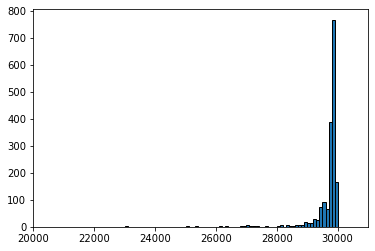

In [60]:
bins = np.arange(0, 31000, 100)
plt.figure()
ax = plt.gca()
ax.hist(covered, bins=bins, ec="k")
ax.set_xlim([20000,31000])
plt.show()

In [ ]:
re.sub()